In [21]:
from utilities.data_functions import col_to_edge_list
from utilities.vis_helpers import plot_coloring
from algorithms.color_gcn import ColorGCN
import torch
import torch.optim as optim
from utilities.eval import dot_product_loss, count_collisions
from utilities.helpers import get_device

device = get_device()

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj


class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.W = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        out = self.W(out)
        return out


class ColorGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super().__init__()
        self.dropout = dropout

        self.layers = nn.ModuleList()
        self.layers.append(GraphConvolution(input_dim, hidden_dim))

        for _ in range(num_layers - 2):
            self.layers.append(GraphConvolution(hidden_dim, hidden_dim))

        self.layers.append(GraphConvolution(hidden_dim, output_dim))

        self.adj_normalized = None

    def forward(self, x, edge_index):
        if self.adj_normalized is None:
            self._make_adj(edge_index)

        for i, layer in enumerate(self.layers):
            x = layer(x, self.adj_normalized)
            # Apply activation and dropout for all layers except the last one
            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.softmax(x)
        return x

    def _make_adj(self, edge_index):
        # Create the adjacency matrix from an edge index
        adj = to_dense_adj(edge_index).squeeze(0)

        # Add self-loops and normalize the adjacency matrix
        # adj = adj + torch.eye(adj.size(0)).to(adj.device)
        # D = torch.diag(torch.sum(adj, dim=1) ** (-0.5))
        # self.adj_normalized = torch.matmul(torch.matmul(D, adj), D)
        self.adj_normalized = adj
        self.adj_normalized.to(edge_index.device)


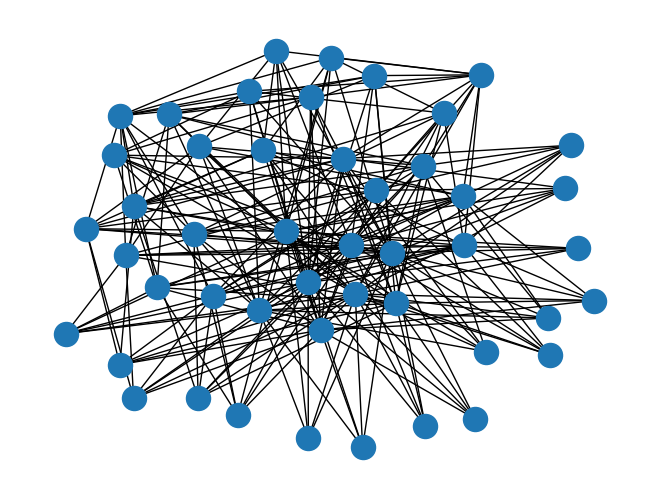

In [46]:
# Load and plot the graph

graph = 'myciel5.col'
n, edge_list, col_list = col_to_edge_list(f'data/input/COLOR/instances/{graph}')
plot_coloring(edge_list)

In [49]:
# Run the graph model
input_dim = 43
hidden_dim = 22
output_dim = 6
num_layers = 3
epochs = 100000

model = ColorGCN(input_dim, hidden_dim, output_dim, num_layers, dropout=0.1).to(device)
edge_list = edge_list.to(device)
graph_rep = torch.randn((n, input_dim)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(graph_rep, edge_list)
    loss = dot_product_loss(out, edge_list)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        model.eval()
        with torch.no_grad():
            out = model(graph_rep, edge_list)
        coloring = torch.argmax(out, dim=1)
        collisions = count_collisions(coloring, edge_list)
        print(f'{i}: {collisions}')
        if collisions == 0:
            break
        # print(f'{i}: {loss}')



/tmp/ipykernel_9805/1922644413.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


0: 40.0
1000: 14.0
2000: 2.5
3000: 2.5
4000: 1.5
5000: 2.5
6000: 1.5
7000: 1.5
8000: 0.5
9000: 0.5
10000: 0.5
11000: 0.5
12000: 0.5
13000: 0.5
14000: 0.5
15000: 0.5
16000: 0.5
17000: 0.5
18000: 0.5
19000: 0.5
20000: 0.5
21000: 0.5
22000: 0.5
23000: 0.5
24000: 0.5
25000: 0.5
26000: 0.5
27000: 0.5
28000: 0.5
29000: 0.5
30000: 0.5
31000: 0.5
32000: 0.5
33000: 0.5
34000: 0.5
35000: 0.5
36000: 0.5
37000: 0.5
38000: 0.5
39000: 0.5
40000: 0.5
41000: 0.5
42000: 0.5
43000: 0.5
44000: 0.5
45000: 0.5
46000: 0.5
47000: 0.5
48000: 0.5
49000: 0.5
50000: 0.5
51000: 0.5
52000: 0.5
53000: 0.5
54000: 0.5
55000: 0.5
56000: 0.5
57000: 0.5
58000: 0.5
59000: 0.5
60000: 0.5
61000: 0.5
62000: 0.5
63000: 0.5
64000: 0.5
65000: 0.5
66000: 0.5
67000: 0.5
68000: 0.5
69000: 0.5


KeyboardInterrupt: 

In [ ]:
# Plot the colored graph

plot_coloring(edge_list, coloring)
